In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

shop_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv', index_col='shop_id')
shop_df['City'] = shop_df.shop_name.str.extract('([А-Яа-я\.]+)', expand=False)
shop_df['big'] = shop_df.shop_name.str.extract('(ТЦ|ТРЦ|ТРК|ТК|Выезд|Онлайн|Интернет)', expand=False)
shop_df['big'].fillna(value="ДР", inplace=True)
shop_df.drop('shop_name', axis=1, inplace=True)

shop_df['City'] = LabelEncoder().fit_transform(shop_df['City'])
shop_df['big'] = LabelEncoder().fit_transform(shop_df['big'])

#print(shop_df.describe())
#print(shop_df.head())

item_categories_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv', index_col='item_category_id')
extraction_str = '(Аксессуары|Игровые консоли|Игры|ТК|Карты оплаты|Кино|Книги|Музыка|Программы|Подарки|Билеты|Доставка товара|Наушники)'
item_categories_df['genre'] = item_categories_df.item_category_name.str.extract(extraction_str, expand=False)
item_categories_df['genre'].fillna(value="Прочее", inplace=True)
item_categories_df['genre'] = LabelEncoder().fit_transform(item_categories_df['genre'])
item_categories_df.drop('item_category_name', axis=1, inplace=True)
#item_categories_df.drop(['item_category_name'], axis=1, inplace=True)
#print(item_categories_df.head(60))

items_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv', index_col='item_id')
items_df = items_df.join(item_categories_df, on='item_category_id', lsuffix="_cal")
items_df.drop('item_name', axis=1, inplace=True)


sales_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')#, index_col='item_id')

sales_train.drop(sales_train.loc[sales_train['item_price']<0,:].index, axis=0, inplace=True)

sales_train['date_parsed'] = pd.to_datetime(sales_train['date'], format="%d.%m.%Y")
sales_train['year'] = sales_train['date_parsed'].dt.year
sales_train['month'] = sales_train['date_parsed'].dt.month

sales_train['item_cnt_day'] = sales_train['item_cnt_day'].clip(0.0, 20.0)

sales_train['item_cnt_month'] = sales_train.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].transform("sum").clip(0.0, 20.0)
sales_train.drop_duplicates(subset=['date_block_num','shop_id', 'item_id'], inplace=True)

sales_train = sales_train[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']]


X_test_full = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv', index_col='ID')


print(sales_train.columns)

print("X_test_full.shape: ",X_test_full.shape)
print("Original sales_train.shape: ",sales_train.shape)

test_shop_ids = X_test_full['shop_id'].unique()
test_item_ids = X_test_full['item_id'].unique()
# Only shops that exist in test set.
sales_train = sales_train[sales_train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
sales_train = sales_train[sales_train['item_id'].isin(test_item_ids)]

print("Usefull sales_train.shape: ",sales_train.shape)

sales_train.head(5)

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month'], dtype='object')
X_test_full.shape:  (214200, 2)
Original sales_train.shape:  (1609124, 4)
Usefull sales_train.shape:  (600159, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,59,22154,1.0
10,0,25,2574,13.0
23,0,25,2607,2.0
56,0,25,2614,2.0
91,0,25,2808,20.0


In [3]:
sales_train.describe()


,date_block_num,shop_id,item_id,item_cnt_month
count,600159.000000,600159.000000,600159.000000,600159.000000
mean,20.158763,32.061657,10014.881568,2.282650
std,9.139355,16.889789,6192.909628,2.912707
min,0.000000,2.000000,30.000000,0.000000
25%,13.000000,19.000000,4395.000000,1.000000
50%,22.000000,31.000000,9089.000000,1.000000
75%,28.000000,47.000000,15374.000000,2.000000
max,33.000000,59.000000,22167.000000,20.000000


In [4]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = X_test_full['shop_id'].unique()
item_ids = X_test_full['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, sales_train, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

#print(item_ids)
train_monthly

,date_block_num,shop_id,item_id,item_cnt_month
0,0,5,5037,0.0
1,0,5,5320,0.0
2,0,5,5233,0.0
3,0,5,5232,0.0
4,0,5,5268,0.0
...,...,...,...,...
7282795,33,45,18454,1.0
7282796,33,45,16188,0.0
7282797,33,45,15757,0.0
7282798,33,45,19648,0.0


In [5]:
def getcol(sales_train):

    sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
    sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
    sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11

    #sales_train = sales_train.join(shop_df, on='shop_id', lsuffix="_cal")
    sales_train = sales_train.join(items_df, on='item_id', lsuffix="_cal")
    
    #sales_train['shop_item_id'] = sales_train['shop_id'] + sales_train['item_id']*100    
    
    return sales_train

#train_monthly = train_monthly.query('item_price < 400000')

train_monthly_ad = getcol(train_monthly)
X_test_full_ad = getcol(X_test_full)

train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))


X_test_full_ad['date_block_num'] = 34
X_test_full_ad['year'] = 2015
X_test_full_ad['month'] = 11

train_monthly

,date_block_num,shop_id,item_id,item_cnt_month,year,month
0,0,5,5037,0.0,2013,0
1,0,5,5320,0.0,2013,0
2,0,5,5233,0.0,2013,0
3,0,5,5232,0.0,2013,0
4,0,5,5268,0.0,2013,0
...,...,...,...,...,...,...
7282795,33,45,18454,1.0,2015,9
7282796,33,45,16188,0.0,2015,9
7282797,33,45,15757,0.0,2015,9
7282798,33,45,19648,0.0,2015,9


In [6]:
train_monthly.tail(20)

,date_block_num,shop_id,item_id,item_cnt_month,year,month
7282780,33,45,19889,0.0,2015,9
7282781,33,45,20650,0.0,2015,9
7282782,33,45,5665,0.0,2015,9
7282783,33,45,9978,0.0,2015,9
7282784,33,45,10767,0.0,2015,9
7282785,33,45,14443,0.0,2015,9
7282786,33,45,14341,0.0,2015,9
7282787,33,45,5401,1.0,2015,9
7282788,33,45,9500,0.0,2015,9
7282789,33,45,16007,0.0,2015,9


In [7]:


train_monthly_ad_reset_index = train_monthly_ad.reset_index()
last_train_index = train_monthly_ad_reset_index.last_valid_index()
print(last_train_index)
sum_df = train_monthly_ad.append(X_test_full_ad, ignore_index = True)

sum_df['year'] = sum_df['date_block_num'].apply(lambda x: ((x//12) + 2013))
sum_df['month'] = sum_df['date_block_num'].apply(lambda x: (x % 12))

7282799


In [8]:
sum_df.head(60)

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,genre,year,month
0,0,5,5037,0.0,19,4,2013,0
1,0,5,5320,0.0,55,8,2013,0
2,0,5,5233,0.0,19,4,2013,0
3,0,5,5232,0.0,23,4,2013,0
4,0,5,5268,0.0,20,4,2013,0
5,0,5,5039,0.0,23,4,2013,0
6,0,5,5041,0.0,20,4,2013,0
7,0,5,5046,0.0,55,8,2013,0
8,0,5,5319,0.0,55,8,2013,0
9,0,5,5003,0.0,20,4,2013,0


In [9]:
sum_df.loc[last_train_index-1:,:]

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,genre,year,month
7282798,33,45,19648,0.0,40,6,2015,9
7282799,33,45,969,0.0,37,6,2015,9
7282800,34,5,5037,NaN,19,4,2015,10
7282801,34,5,5320,NaN,55,8,2015,10
7282802,34,5,5233,NaN,19,4,2015,10
...,...,...,...,...,...,...,...,...
7496995,34,45,18454,NaN,55,8,2015,10
7496996,34,45,16188,NaN,64,10,2015,10
7496997,34,45,15757,NaN,55,8,2015,10
7496998,34,45,19648,NaN,40,6,2015,10


In [10]:
lag_list = [1,2,3]
#for lag in lag_list:
#    ft_name = 'itm_sh'+str(lag)
#    sum_df[ft_name] = sum_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)
#    sum_df[ft_name].fillna(0, inplace=True)
#sum_df['icm_mean'] = sum_df.sort_values('date_block_num').groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_month'].transform('mean')
sum_df['icm_mean_sh1'] = sum_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(1)
sum_df['icm_mean_sh1'].fillna(value=0, inplace=True)
sum_df['icm_mean_sh2'] = sum_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(2)
sum_df['icm_mean_sh2'].fillna(value=0, inplace=True)
sum_df['icm_mean_sh3'] = sum_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(3)
sum_df['icm_mean_sh3'].fillna(value=0, inplace=True)

#sum_df.sort_values('date_block_num').groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_month'].mean()
sum_df



,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,genre,year,month,icm_mean_sh1,icm_mean_sh2,icm_mean_sh3
0,0,5,5037,0.0,19,4,2013,0,0.0,0.0,0.0
1,0,5,5320,0.0,55,8,2013,0,0.0,0.0,0.0
2,0,5,5233,0.0,19,4,2013,0,0.0,0.0,0.0
3,0,5,5232,0.0,23,4,2013,0,0.0,0.0,0.0
4,0,5,5268,0.0,20,4,2013,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7496995,34,45,18454,NaN,55,8,2015,10,1.0,0.0,0.0
7496996,34,45,16188,NaN,64,10,2015,10,0.0,0.0,0.0
7496997,34,45,15757,NaN,55,8,2015,10,0.0,0.0,0.0
7496998,34,45,19648,NaN,40,6,2015,10,0.0,0.0,0.0


In [11]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Mean value
f_mean6 = lambda x: x.rolling(window=6, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

#for i in range(len(function_list)):
#    sum_df[('item_cnt_%s' % function_name[i])] = sum_df.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt_month'].apply(function_list[i])

sum_df['item_cnt_mean_3m'] = sum_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].apply(f_mean)
#sum_df['item_cnt_mean_6m'] = sum_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].apply(f_mean6)
sum_df['item_cnt_max_3m'] = sum_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].apply(f_max)
sum_df['item_cnt_min_3m'] = sum_df.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].apply(f_min)


# Fill the empty features with 0
#sum_df['item_cnt_std'].fillna(0, inplace=True)
#sum_df['item_cnt_max'].fillna(0, inplace=True)
#sum_df['item_cnt_mean'].fillna(0, inplace=True)
#sum_df['item_cnt_min'].fillna(0, inplace=True)

sum_df.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,5.0,5.0,5.0,5.0,5.0
item_id,5037.0,5320.0,5233.0,5232.0,5268.0
item_cnt_month,0.0,0.0,0.0,0.0,0.0
item_category_id,19.0,55.0,19.0,23.0,20.0
genre,4.0,8.0,4.0,4.0,4.0
year,2013.0,2013.0,2013.0,2013.0,2013.0
month,0.0,0.0,0.0,0.0,0.0
icm_mean_sh1,0.0,0.0,0.0,0.0,0.0
icm_mean_sh2,0.0,0.0,0.0,0.0,0.0


In [12]:
#sum_df[sum_df['year'] == 0.0]

In [13]:
#trend = food_sales.rolling(
#    window=12,       
#    center=True,     
#    min_periods=6
#).mean() 

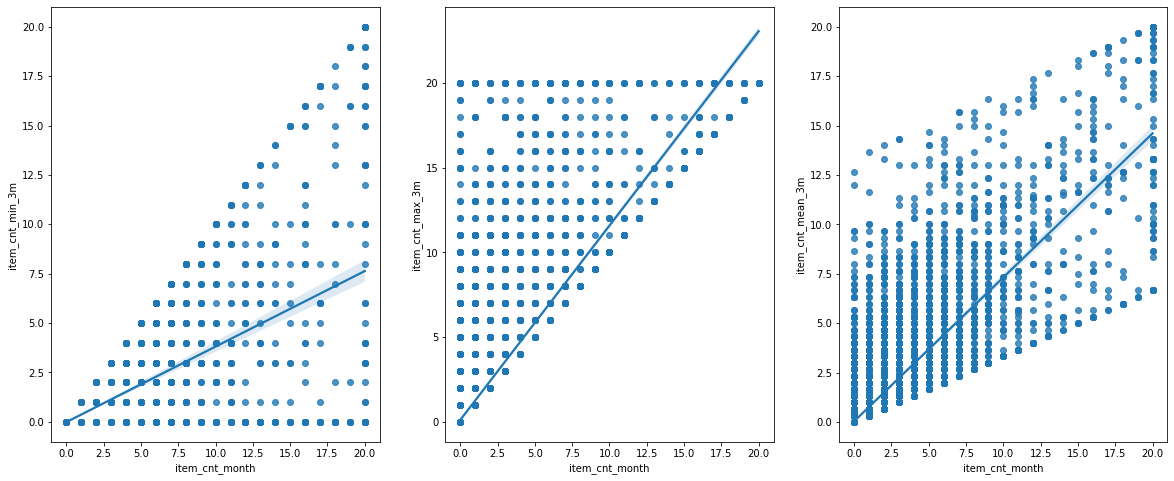

In [14]:

import seaborn as sns
import matplotlib.pyplot as plt


a = sum_df[sum_df['shop_id'] == 24]


#plt.figure(figsize=(18,6))

fig ,axes = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
axes[0]=sns.regplot(x='item_cnt_month', y='item_cnt_min_3m',data=a, ax=axes[0])
axes[1]=sns.regplot(x='item_cnt_month', y='item_cnt_max_3m',data=a, ax=axes[1])
axes[2]=sns.regplot(x='item_cnt_month', y='item_cnt_mean_3m',data=a, ax=axes[2])
plt.show()

In [15]:
train_df = sum_df.loc[:last_train_index,:]
test_df = sum_df.loc[last_train_index+1:,:].reset_index()
test_df

,index,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,genre,year,month,icm_mean_sh1,icm_mean_sh2,icm_mean_sh3,item_cnt_mean_3m,item_cnt_max_3m,item_cnt_min_3m
0,7282800,34,5,5037,NaN,19,4,2015,10,0.0,1.0,3.0,0.5,1.0,0.0
1,7282801,34,5,5320,NaN,55,8,2015,10,0.0,0.0,0.0,0.0,0.0,0.0
2,7282802,34,5,5233,NaN,19,4,2015,10,1.0,3.0,1.0,2.0,3.0,1.0
3,7282803,34,5,5232,NaN,23,4,2015,10,0.0,0.0,1.0,0.0,0.0,0.0
4,7282804,34,5,5268,NaN,20,4,2015,10,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,7496995,34,45,18454,NaN,55,8,2015,10,1.0,0.0,0.0,0.5,1.0,0.0
214196,7496996,34,45,16188,NaN,64,10,2015,10,0.0,0.0,0.0,0.0,0.0,0.0
214197,7496997,34,45,15757,NaN,55,8,2015,10,0.0,0.0,0.0,0.0,0.0,0.0
214198,7496998,34,45,19648,NaN,40,6,2015,10,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
test_df[test_df['item_cnt_mean_3m']>5].head(20)

,index,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,genre,year,month,icm_mean_sh1,icm_mean_sh2,icm_mean_sh3,item_cnt_mean_3m,item_cnt_max_3m,item_cnt_min_3m
54,7282854,34,5,3731,NaN,30,4,2015,10,8.0,3.0,14.0,5.5,8.0,3.0
55,7282855,34,5,4719,NaN,30,4,2015,10,4.0,11.0,0.0,7.5,11.0,4.0
58,7282858,34,5,3350,NaN,19,4,2015,10,8.0,15.0,0.0,11.5,15.0,8.0
59,7282859,34,5,3351,NaN,20,4,2015,10,4.0,20.0,0.0,12.0,20.0,4.0
60,7282860,34,5,3352,NaN,23,4,2015,10,9.0,8.0,0.0,8.5,9.0,8.0
118,7282918,34,5,9355,NaN,70,10,2015,10,8.0,16.0,18.0,12.0,16.0,8.0
152,7282952,34,5,10202,NaN,20,4,2015,10,16.0,0.0,0.0,8.0,16.0,0.0
255,7283055,34,5,7223,NaN,20,4,2015,10,16.0,0.0,0.0,8.0,16.0,0.0
274,7283074,34,5,17717,NaN,79,12,2015,10,12.0,19.0,19.0,15.5,19.0,12.0
346,7283146,34,5,14227,NaN,30,4,2015,10,6.0,8.0,7.0,7.0,8.0,6.0


In [17]:
test_df[test_df['item_cnt_mean_3m']>2].head(20)

,index,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,genre,year,month,icm_mean_sh1,icm_mean_sh2,icm_mean_sh3,item_cnt_mean_3m,item_cnt_max_3m,item_cnt_min_3m
6,7282806,34,5,5041,NaN,20,4,2015,10,2.0,3.0,0.0,2.5,3.0,2.0
10,7282810,34,5,4806,NaN,30,4,2015,10,3.0,2.0,5.0,2.5,3.0,2.0
15,7282815,34,5,4872,NaN,19,4,2015,10,6.0,1.0,2.0,3.5,6.0,1.0
24,7282824,34,5,5900,NaN,30,4,2015,10,3.0,3.0,2.0,3.0,3.0,3.0
29,7282829,34,5,5675,NaN,3,0,2015,10,7.0,3.0,5.0,5.0,7.0,3.0
42,7282842,34,5,5821,NaN,35,5,2015,10,4.0,3.0,5.0,3.5,4.0,3.0
43,7282843,34,5,5822,NaN,35,5,2015,10,3.0,4.0,8.0,3.5,4.0,3.0
54,7282854,34,5,3731,NaN,30,4,2015,10,8.0,3.0,14.0,5.5,8.0,3.0
55,7282855,34,5,4719,NaN,30,4,2015,10,4.0,11.0,0.0,7.5,11.0,4.0
56,7282856,34,5,3341,NaN,19,4,2015,10,0.0,7.0,8.0,3.5,7.0,0.0


In [18]:
test_df.describe()

,index,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,genre,year,month,icm_mean_sh1,icm_mean_sh2,icm_mean_sh3,item_cnt_mean_3m,item_cnt_max_3m,item_cnt_min_3m
count,2.142000e+05,214200.0,214200.000000,214200.000000,0.0,214200.000000,214200.000000,214200.0,214200.0,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000,214200.000000
mean,7.389900e+06,34.0,31.666667,11019.398627,NaN,46.309608,6.926667,2015.0,10.0,0.256153,0.246965,0.260467,0.251559,0.402236,0.100882
std,6.183436e+04,0.0,17.533229,6252.644590,NaN,16.716581,2.364555,0.0,0.0,1.090817,1.116966,1.032491,0.961542,1.384863,0.688682
min,7.282800e+06,34.0,2.000000,30.000000,NaN,0.000000,0.000000,2015.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.336350e+06,34.0,16.000000,5381.500000,NaN,37.000000,6.000000,2015.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.389900e+06,34.0,34.500000,11203.000000,NaN,43.000000,7.000000,2015.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.443449e+06,34.0,47.000000,16071.500000,NaN,58.000000,8.000000,2015.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.496999e+06,34.0,59.000000,22167.000000,NaN,83.000000,12.000000,2015.0,10.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000


In [19]:
test_df.isna().sum()

index                    0
date_block_num           0
shop_id                  0
item_id                  0
item_cnt_month      214200
item_category_id         0
genre                    0
year                     0
month                    0
icm_mean_sh1             0
icm_mean_sh2             0
icm_mean_sh3             0
item_cnt_mean_3m         0
item_cnt_max_3m          0
item_cnt_min_3m          0
dtype: int64

In [20]:
from sklearn.model_selection import train_test_split

X_test_full_ad =test_df

X_train_full_ = train_df[train_df['date_block_num'] > 3]
X_train_full = X_train_full_[X_train_full_['date_block_num'] < 33]
#X_train_full = train_df
X_valid_full = train_df[train_df['date_block_num'] == 33]

y_train = X_train_full['item_cnt_month']
y_valid = X_valid_full['item_cnt_month']


boost_cols = [
 'date_block_num',
 'icm_mean_sh1',
 'icm_mean_sh2',
 'icm_mean_sh3',
 'item_cnt_mean_3m',
 #'item_cnt_mean_6m',
 'item_cnt_max_3m',
 'item_cnt_min_3m',
 'shop_id',
 'item_id',
# 'shop_item_id',
 'item_category_id',  
 'year',
 'month',
 #'genre',
]
encode_cols = [
 'shop_id',
 'item_id',
# 'shop_item_id',
 'item_category_id',  
 #'genre',
]

X_train_ = X_train_full[boost_cols]
X_valid_ = X_valid_full[boost_cols]
X_test_ = X_test_full_ad[boost_cols]
print(X_train_.shape)
print(X_train_.columns)
print('done!')

X_test_.isna().sum()

(6211800, 12)
Index(['date_block_num', 'icm_mean_sh1', 'icm_mean_sh2', 'icm_mean_sh3',
       'item_cnt_mean_3m', 'item_cnt_max_3m', 'item_cnt_min_3m', 'shop_id',
       'item_id', 'item_category_id', 'year', 'month'],
      dtype='object')
done!


date_block_num      0
icm_mean_sh1        0
icm_mean_sh2        0
icm_mean_sh3        0
item_cnt_mean_3m    0
item_cnt_max_3m     0
item_cnt_min_3m     0
shop_id             0
item_id             0
item_category_id    0
year                0
month               0
dtype: int64

In [21]:

from category_encoders import MEstimateEncoder


#bypass line regressor
#boost_cols +=line_cols
y_train_boost = y_train

est_enc = MEstimateEncoder(cols=encode_cols)

est_enc.fit(X_train_[encode_cols], y_train)

X_train_to_boost_model = X_train_.copy()
X_train_to_boost_model[encode_cols] = est_enc.transform(X_train_[encode_cols])

X_valid_to_boost_model = X_valid_.copy()
X_valid_to_boost_model[encode_cols] = est_enc.transform(X_valid_[encode_cols])

X_test_to_boost_model = X_test_.copy()
X_test_to_boost_model[encode_cols] = est_enc.transform(X_test_[encode_cols])

#X_train_to_boost_model = X_train_
#X_valid_to_boost_model = X_valid_
#X_test_to_boost_model = X_test_

X_train_to_boost_model

,date_block_num,icm_mean_sh1,icm_mean_sh2,icm_mean_sh3,item_cnt_mean_3m,item_cnt_max_3m,item_cnt_min_3m,shop_id,item_id,item_category_id,year,month
856800,4,0.0,0.0,0.0,0.0,0.0,0.0,0.141515,0.915667,0.529162,2013,4
856801,4,0.0,0.0,0.0,0.0,0.0,0.0,0.141515,0.000162,0.195289,2013,4
856802,4,0.0,0.0,0.0,0.0,0.0,0.0,0.141515,0.366036,0.529162,2013,4
856803,4,0.0,0.0,0.0,0.0,0.0,0.0,0.141515,0.092041,0.443121,2013,4
856804,4,0.0,0.0,0.0,0.0,0.0,0.0,0.141515,0.000162,0.443097,2013,4
...,...,...,...,...,...,...,...,...,...,...,...,...
7068595,32,0.0,0.0,0.0,0.0,0.0,0.0,0.120900,0.375060,0.195289,2015,8
7068596,32,0.0,0.0,0.0,0.0,0.0,0.0,0.120900,0.002623,0.149586,2015,8
7068597,32,0.0,0.0,0.0,0.0,0.0,0.0,0.120900,0.215092,0.195289,2015,8
7068598,32,0.0,0.0,0.0,0.0,0.0,0.0,0.120900,0.038718,0.140651,2015,8


In [22]:
X_test_to_boost_model.isna().sum()

date_block_num      0
icm_mean_sh1        0
icm_mean_sh2        0
icm_mean_sh3        0
item_cnt_mean_3m    0
item_cnt_max_3m     0
item_cnt_min_3m     0
shop_id             0
item_id             0
item_category_id    0
year                0
month               0
dtype: int64

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [24]:
from xgboost import XGBRegressor
ts = time.time()


# X_train, X_valid, y_train, y_valid 

model_xgb = XGBRegressor(
    tree_method='gpu_hist',
    gpu_id=0,
    max_depth=8,
    n_estimators=150,
    min_child_weight=300, 
    colsample_bytree=0.7, 
    subsample=0.7, 
    eta=0.3,    
    seed=0)

model_xgb.fit(
    X_train_to_boost_model, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_valid_to_boost_model, y_valid)], 
    verbose=10, 
    early_stopping_rounds = 10)#

test_preds_xgb = model_xgb.predict(X_train_to_boost_model)
print( "Train set ", "RMSE: ", mean_squared_error(y_train, test_preds_xgb, squared=False))

preds_valid_xgb = model_xgb.predict(X_valid_to_boost_model)
print( "Valid set RMSE: ", mean_squared_error(y_valid, preds_valid_xgb, squared=False)) 
time.time() - ts

[0]	validation_0-rmse:0.84867
[10]	validation_0-rmse:0.22848
[20]	validation_0-rmse:0.13551
[30]	validation_0-rmse:0.10728
[40]	validation_0-rmse:0.09169
[50]	validation_0-rmse:0.07864
[60]	validation_0-rmse:0.07125
[70]	validation_0-rmse:0.06594
[80]	validation_0-rmse:0.06180
[90]	validation_0-rmse:0.05977
[100]	validation_0-rmse:0.05754
[110]	validation_0-rmse:0.05541
[120]	validation_0-rmse:0.05352
[130]	validation_0-rmse:0.05152
[140]	validation_0-rmse:0.05051
[149]	validation_0-rmse:0.04908
Train set  RMSE:  0.04571617629424743
Valid set RMSE:  0.04907663053267688


35.10432839393616

In [25]:
#print(model_xgb.best_params_)
model_xgb.get_booster().get_score(importance_type='gain')

{'date_block_num': 11.4057035446167,
 'icm_mean_sh1': 858.198486328125,
 'icm_mean_sh2': 688.4002075195312,
 'icm_mean_sh3': 79.17213439941406,
 'item_cnt_mean_3m': 3370.783203125,
 'item_cnt_max_3m': 2797.087646484375,
 'item_cnt_min_3m': 335.8943786621094,
 'shop_id': 13.516654014587402,
 'item_id': 26.84565544128418,
 'item_category_id': 28.918460845947266,
 'year': 4.953176021575928,
 'month': 71.9648666381836}

In [26]:

from catboost import CatBoostRegressor
from catboost import Pool
ts = time.time()

catboost_model = CatBoostRegressor(
    iterations=150,
    max_ctr_complexity=4,
    random_seed=0,
    #task_type="GPU",
    #devices='0:1',
    od_type='Iter',
    od_wait=25,
    verbose=25,
    depth=4
)

catboost_model.fit(
    X_train_to_boost_model, y_train,
    #cat_features=cat_features,
    eval_set=(X_valid_to_boost_model, y_valid)
)

test_preds_cat = catboost_model.predict(X_train_to_boost_model)
print( "Train set RMSE: ", mean_squared_error(y_train, test_preds_cat, squared=False))

preds_valid_cat = catboost_model.predict(X_valid_to_boost_model)
print( "Valid set RMSE: ", mean_squared_error(y_valid, preds_valid_cat, squared=False))

time.time() - ts

Learning rate set to 0.5
0:	learn: 0.7459819	test: 0.7801503	best: 0.7801503 (0)	total: 990ms	remaining: 2m 27s
25:	learn: 0.1630154	test: 0.1717478	best: 0.1717478 (25)	total: 14s	remaining: 1m 6s
50:	learn: 0.1034161	test: 0.1068203	best: 0.1068203 (50)	total: 27.4s	remaining: 53.2s
75:	learn: 0.0762394	test: 0.0757547	best: 0.0757547 (75)	total: 40.7s	remaining: 39.7s
100:	learn: 0.0614742	test: 0.0617819	best: 0.0617819 (100)	total: 53.5s	remaining: 25.9s
125:	learn: 0.0528297	test: 0.0535604	best: 0.0535604 (125)	total: 1m 6s	remaining: 12.7s
149:	learn: 0.0460364	test: 0.0467728	best: 0.0467728 (149)	total: 1m 19s	remaining: 0us

bestTest = 0.04677278982
bestIteration = 149

Train set RMSE:  0.04603638167239687
Valid set RMSE:  0.046772789824642544


82.97949719429016

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

feature_score = catboost_model.get_feature_importance()

scores = list(zip(X_train_to_boost_model.columns.values,feature_score))

for item in scores:
    print(item)

('date_block_num', 0.0)
('icm_mean_sh1', 14.584445812062162)
('icm_mean_sh2', 17.52735686850742)
('icm_mean_sh3', 0.0)
('item_cnt_mean_3m', 39.03845451805695)
('item_cnt_max_3m', 19.449195386867043)
('item_cnt_min_3m', 9.40054741450643)
('shop_id', 0.0)
('item_id', 0.0)
('item_category_id', 0.0)
('year', 0.0)
('month', 0.0)


In [28]:
from sklearn.ensemble import RandomForestRegressor

ts = time.time()

rf_model = RandomForestRegressor(n_estimators=10, max_depth=8, random_state=0, verbose=2)

rf_model.fit(X_train_to_boost_model, y_train)


test_preds_rf = rf_model.predict(X_train_to_boost_model)
print( "Train set ", "RMSE: ", mean_squared_error(y_train, test_preds_rf, squared=False))

preds_valid_rf = rf_model.predict(X_valid_to_boost_model)
print( "Valid RMSE: ", mean_squared_error(y_valid, preds_valid_rf, squared=False))

time.time() - ts

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Train set  RMSE:  0.1356781747097772
Valid RMSE:  0.1558418220305272


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


70.24468755722046

In [29]:
print( "Valid RMSE: ", mean_squared_error(y_valid, preds_valid_cat, squared=False))
print( "Valid RMSE: ", mean_squared_error(y_valid, preds_valid_cat.clip(0,20.0), squared=False))

Valid RMSE:  0.046772789824642544
Valid RMSE:  0.04536554745498644


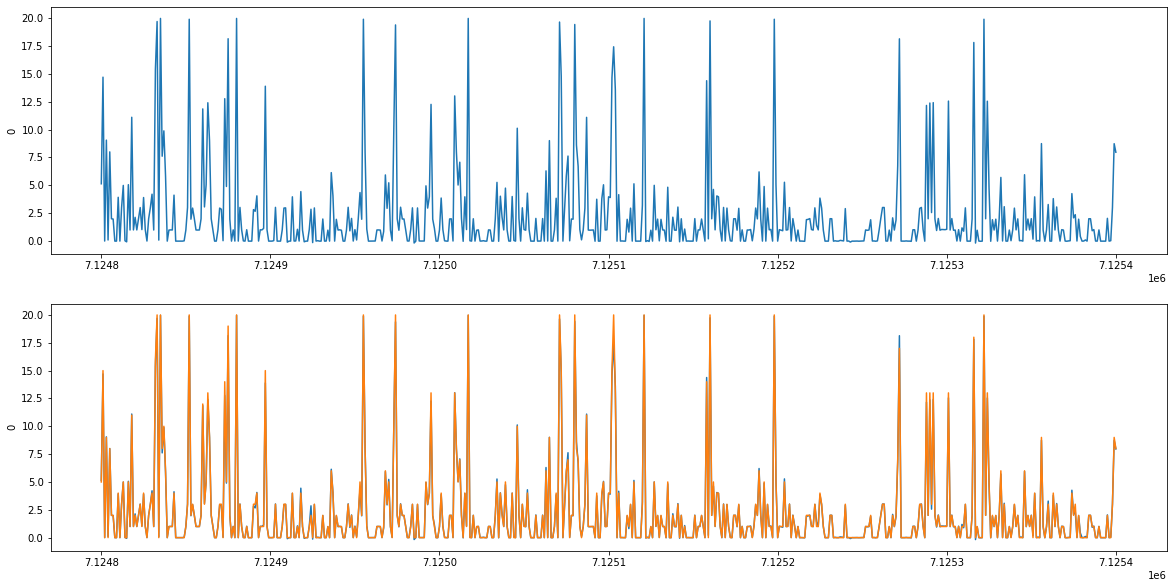

In [30]:
#y_valid, preds
preds = preds_valid_xgb
preds_= pd.DataFrame(preds, index=y_valid.index)
start_point = preds_.index.values[0]+56200
stop_point = start_point + 600

plot_df = preds_.loc[start_point:stop_point]#.drop_duplicates()
plot_valid = pd.DataFrame(y_valid).loc[start_point:stop_point]#.drop_duplicates()

fig ,axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
#axes[0][0]=sns.regplot(x='item_cnt_month', y='icm_mean_sh1',data=a, ax=axes[0][0])
#plt.figure(figsize=(22,6))
axes[0] = sns.lineplot(x=plot_df.index, y=plot_df[0], data=plot_df, ax=axes[0])
axes[1] = sns.lineplot(x=plot_df.index, y=plot_df[0], data=plot_df, ax=axes[1])
axes[1] = sns.lineplot(x=plot_valid.index, y=plot_valid['item_cnt_month'], data=plot_valid, ax=axes[1])

#plot_valid

In [31]:
#from sklearn.neural_network import MLPRegressor
#from sklearn.preprocessing import StandardScaler, MinMaxScaler

#mpl_scaler = MinMaxScaler()
#mpl_scaler.fit(X_train)

#mpl_train = mpl_scaler.transform(X_train)
#mpl_val = mpl_scaler.transform(X_valid)
#mpl_test = mpl_scaler.transform(X_test)

#mpl_model = MLPRegressor(random_state=1, max_iter=500)

#mpl_model.fit(mpl_train, y_train)

#preds = rf_model.predict(mpl_val)
#print( "RMSE: ", mean_squared_error(y_valid, preds, squared=False), "  MAE: ", mean_absolute_error(y_valid, preds))

In [32]:
test_model = catboost_model

preds_test_cat = catboost_model.predict(X_test_to_boost_model).clip(0.0, 20.0)
preds_test_xgb = model_xgb.predict(X_test_to_boost_model).clip(0.0, 20.0)
preds_test_rf = model_xgb.predict(X_test_to_boost_model).clip(0.0, 20.0)

output = pd.DataFrame({'ID': X_test_.index,
                       'item_cnt_month': preds_test_xgb})
#output = output['item_cnt_month'].transform(lambda x: x if x>0 else 0)

output.to_csv('/kaggle/working/submission_pfs_1.csv', index=False)

#print(output.head(60))
print("done!")

done!


In [33]:
X_test_to_boost_model['cat'] = preds_test_cat
X_test_to_boost_model['xgb'] = preds_test_xgb
X_test_to_boost_model['rf'] = preds_test_rf
X_test_to_boost_model.head(10)

,date_block_num,icm_mean_sh1,icm_mean_sh2,icm_mean_sh3,item_cnt_mean_3m,item_cnt_max_3m,item_cnt_min_3m,shop_id,item_id,item_category_id,year,month,cat,xgb,rf
0,34,0.0,1.0,3.0,0.5,1.0,0.0,0.141515,0.915667,0.529162,2015,10,0.008116,0.010814,0.010814
1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.141515,0.000162,0.195289,2015,10,0.000447,0.000000,0.000000
2,34,1.0,3.0,1.0,2.0,3.0,1.0,0.141515,0.366036,0.529162,2015,10,1.918814,1.908053,1.908053
3,34,0.0,0.0,1.0,0.0,0.0,0.0,0.141515,0.092041,0.443121,2015,10,0.000447,0.000175,0.000175
4,34,0.0,0.0,0.0,0.0,0.0,0.0,0.141515,0.000162,0.443097,2015,10,0.000447,0.000629,0.000629
5,34,1.0,1.0,0.0,1.0,1.0,1.0,0.141515,0.760622,0.443121,2015,10,1.019142,0.998432,0.998432
6,34,2.0,3.0,0.0,2.5,3.0,2.0,0.141515,0.201967,0.443097,2015,10,2.130270,2.029338,2.029338
7,34,0.0,0.0,0.0,0.0,0.0,0.0,0.141515,0.388185,0.195289,2015,10,0.000447,0.000193,0.000193
8,34,0.0,3.0,2.0,1.5,3.0,0.0,0.141515,1.133058,0.195289,2015,10,1.014891,1.125883,1.125883
9,34,0.0,0.0,0.0,0.0,0.0,0.0,0.141515,0.010006,0.443097,2015,10,0.000447,0.000920,0.000920


In [34]:
X_test_to_boost_model[X_test_to_boost_model['rf']>2]


,date_block_num,icm_mean_sh1,icm_mean_sh2,icm_mean_sh3,item_cnt_mean_3m,item_cnt_max_3m,item_cnt_min_3m,shop_id,item_id,item_category_id,year,month,cat,xgb,rf
6,34,2.0,3.0,0.0,2.5,3.0,2.0,0.141515,0.201967,0.443097,2015,10,2.130270,2.029338,2.029338
10,34,3.0,2.0,5.0,2.5,3.0,2.0,0.141515,2.389006,1.032950,2015,10,2.082872,2.008508,2.008508
14,34,2.0,2.0,3.0,2.0,2.0,2.0,0.141515,4.717143,0.443121,2015,10,2.039105,2.041072,2.041072
15,34,6.0,1.0,2.0,3.5,6.0,1.0,0.141515,2.716323,0.529162,2015,10,2.976318,3.117146,3.117146
18,34,2.0,2.0,2.0,2.0,2.0,2.0,0.141515,0.979654,1.032950,2015,10,2.039105,2.062078,2.062078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210204,34,2.0,4.0,0.0,3.0,4.0,2.0,0.120900,0.250367,0.118701,2015,10,2.957697,3.000243,3.000243
210300,34,2.0,2.0,0.0,2.0,2.0,2.0,0.120900,1.078915,0.443121,2015,10,2.039105,2.044586,2.044586
210335,34,3.0,1.0,4.0,2.0,3.0,1.0,0.120900,0.178177,0.140651,2015,10,2.053748,2.052905,2.052905
210502,34,2.0,2.0,0.0,2.0,2.0,2.0,0.120900,0.165872,0.195289,2015,10,2.039105,2.014103,2.014103


In [35]:
X_valid_to_boost_model['cat'] = preds_test_cat
X_valid_to_boost_model['xgb'] = preds_test_xgb
X_valid_to_boost_model['rf'] = preds_test_rf
X_valid_to_boost_model['y'] = y_valid

X_valid_to_boost_model[X_valid_to_boost_model['y'] > 2]

,date_block_num,icm_mean_sh1,icm_mean_sh2,icm_mean_sh3,item_cnt_mean_3m,item_cnt_max_3m,item_cnt_min_3m,shop_id,item_id,item_category_id,year,month,cat,xgb,rf,y
7068610,33,2.0,5.0,5.0,3.333333,5.0,2.0,0.141515,2.389006,1.032950,2015,9,2.082872,2.008508,2.008508,3.0
7068615,33,1.0,2.0,1.0,3.000000,6.0,1.0,0.141515,2.716323,0.529162,2015,9,2.976318,3.117146,3.117146,6.0
7068624,33,3.0,2.0,1.0,2.666667,3.0,2.0,0.141515,0.383263,1.032950,2015,9,3.021745,2.988538,2.988538,3.0
7068629,33,3.0,5.0,0.0,5.000000,7.0,3.0,0.141515,0.477603,0.521806,2015,9,4.820878,4.930573,4.930573,7.0
7068642,33,3.0,5.0,3.0,4.000000,5.0,3.0,0.141515,3.945199,4.598850,2015,9,3.024938,3.361897,3.361897,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7278932,33,0.0,0.0,0.0,1.000000,3.0,0.0,0.120900,0.756520,0.140651,2015,9,1.031445,1.099905,1.099905,3.0
7278935,33,1.0,4.0,0.0,2.666667,4.0,1.0,0.120900,0.178177,0.140651,2015,9,2.053748,2.052905,2.052905,3.0
7279354,33,0.0,0.0,0.0,1.333333,4.0,0.0,0.120900,0.000983,0.195289,2015,9,2.020622,1.844359,1.844359,4.0
7279436,33,0.0,0.0,0.0,1.666667,5.0,0.0,0.120900,0.000162,0.443097,2015,9,2.100549,1.856626,1.856626,5.0


In [36]:
X_train_to_boost_model['y'] = y_train
a = X_train_to_boost_model[X_train_to_boost_model['shop_id'] == 5]
a[a['item_id']==3731]



,date_block_num,icm_mean_sh1,icm_mean_sh2,icm_mean_sh3,item_cnt_mean_3m,item_cnt_max_3m,item_cnt_min_3m,shop_id,item_id,item_category_id,year,month,y


In [37]:
#for i, (kernel, name) in enumerate(zip(kernels, names)):


#multicategorical_cols = []                                                                
#numerical_cols =[    'date_block_num',    'shop_id',     'item_id']
#train_size=0.5
#RandomForestRegressor
#XGBRegressor 1.62734

#####################
#train_size=0.1
# numerical_cols =[    'date_block_num',    'shop_id',     'item_id']
# XGBRegressor RMSE:  3.0463392634436053
# CatBoostRegressor RMSE: 3.4996434378823618
# RandomForestRegressor  2.571116357048179
# MLPRegressor  RMSE:  5.716962073137371
# + 'year'
# XGBRegressor RMSE:  2.909346544514906
# CatBoostRegressor RMSE: 2.3808507008174056
# RandomForestRegressor   -
# + 'month'
# XGBRegressor RMSE:  2.8240848816805406
# CatBoostRegressor RMSE: 2.8108886853686212
# RandomForestRegressor   2.4987646827685195 
# + 'genre'
# CatBoostRegressor RMSE: 2.730982032330986
# RandomForestRegressor 2.4428646976827815
# - 'genre', 'month' + 'City'
# CatBoostRegressor RMSE:  2.757827686447402
#
# train_size=0.5
# date_block_num',  'shop_item_id'  'shop_id',     'item_id' 'year'
# XGBRegressor RMSE:  2.4772597836369825
# CatBoostRegressor RMSE: 2.8189403230203274
# RandomForestRegressor   2.1428279299884725 